# Pricing Temperature Derivatives using Monte Carlo Techniques

## Overview of CME temperature derivatives

Temperature derivatives traded on CME primarily rely on 2 indices : HDD and CDD which are defined as follows

$$ 
HDD = \sum_{t} max(\theta_{base} - \theta_t , 0)
$$

$$
CDD = \sum_{t} max(\theta_t - \theta_{base} , 0)
$$

Where $ \theta $ represents temperature. 

HDD stands for Heating Degree Days signifying need for heating. While CDD stands for Cooling Degree Days signifying need for cooling.

These 2 values are then used as underlying for the derivatives which can be options, forwards,etc .

A typical payoff for a HDD forward as follows : 

$$
Payoff = \alpha * HDD
$$

Where $ \alpha $ is called the notional. In the case of CME contracts this is $20.

The purpose of these contracts is to hedge against weather risk.

The purpose of this project is to price options on such forwards.



## Overview of Methodology

In one line : I generate a distribution for HDD by simulating temperature paths . Then, I shift the distribution to match its mean to a selected forward price observed on the market. Finally, use the shifted distribution to price the derivate using the Bachelier model. 

Steps :

1. First, fit a sine wave to the temperature data to capture seasonality
2. Find differences of actual temperature from the sine wave
3. Fit a time series model to the differences to generate temperature paths
4. Calculate HDD for each path to generate the HDD distribution
5. Shift such that expected HDD equals the price of a forward 
6. Use the shifted distribution to price an option under the standard Bachelier model and also compute the option greeks 

In [147]:
from datetime import datetime
from meteostat import Point, Daily
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import random
from scipy.optimize import curve_fit
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import norm

In [148]:
location = Point(41.9786, -87.9048, 205)
start = datetime(1980,1,1)
end = datetime(2026,1,1)

data = Daily(location, start, end)
data = data.fetch()

data.index = range(len(data.index))
data['day'] = data.index % 365
data['week'] = data['day'] // 7
data['month'] = data['day'] // 30
data['year'] = data.index // 365


In [149]:
data.head()

data['tavg'] = 32 + 1.8 * data['tavg']

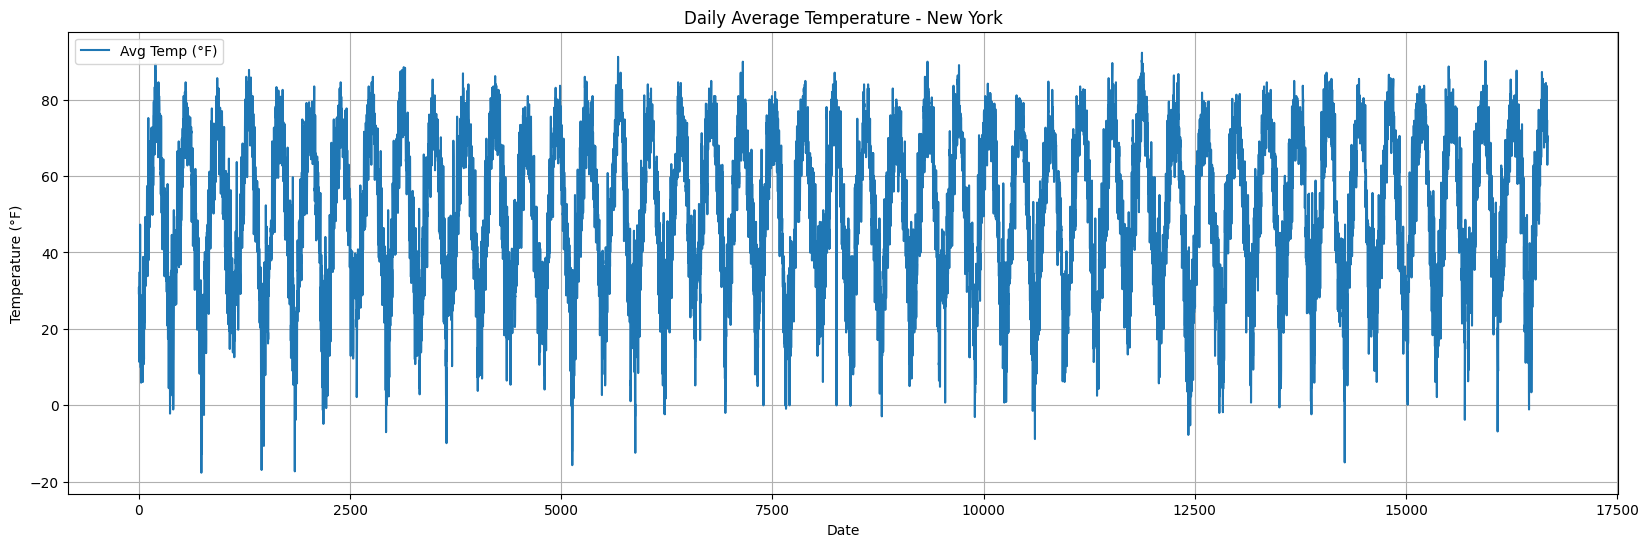

In [150]:
plt.figure(figsize=(20,6))
plt.plot(data.index, data['tavg'], label='Avg Temp (°F)')
plt.title("Daily Average Temperature - New York")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.show()

## The Model

We will be following an AR(p) model (because temperature is expected to mean revert). But since , temperature shows seasonality, instead of having a constant $ \mu $ , we will instead make it harmonic . 

$$
X_t = \mu_t + \phi_1(X_{t-1} - \mu_{t-1}) + \phi_2(X_{t-2} - \mu_{t-2}) +  ... + \epsilon 
$$

$$
\mu_t = A*sin(B*t + \theta)
$$

## Fitting the sine wave

We will first fit the sine wave before we determine which AR(1) model to use

In [151]:
def sine_function(x, A, B, C, D):
        return  A * np.sin(B * x + C)  + D


temp_benchmark = np.mean(data['tavg'])
A_init = 2 * temp_benchmark         # Amplitude ~20°F
B_init = 2 * np.pi / 365   # One cycle per year
C_init = -B_init * 200     # Peak around mid-July
D_init = temp_benchmark                # Average annual temperature
initial_guess = [A_init, B_init, C_init, D_init]
params, _ = curve_fit(sine_function, range(len(data.index)), data['tavg'], p0=initial_guess)
A_fit, B_fit, C_fit, D_fit = params
days = np.sort(np.unique(data['day']))

sine_wave = sine_function(days, A_fit,B_fit,C_fit,D_fit)

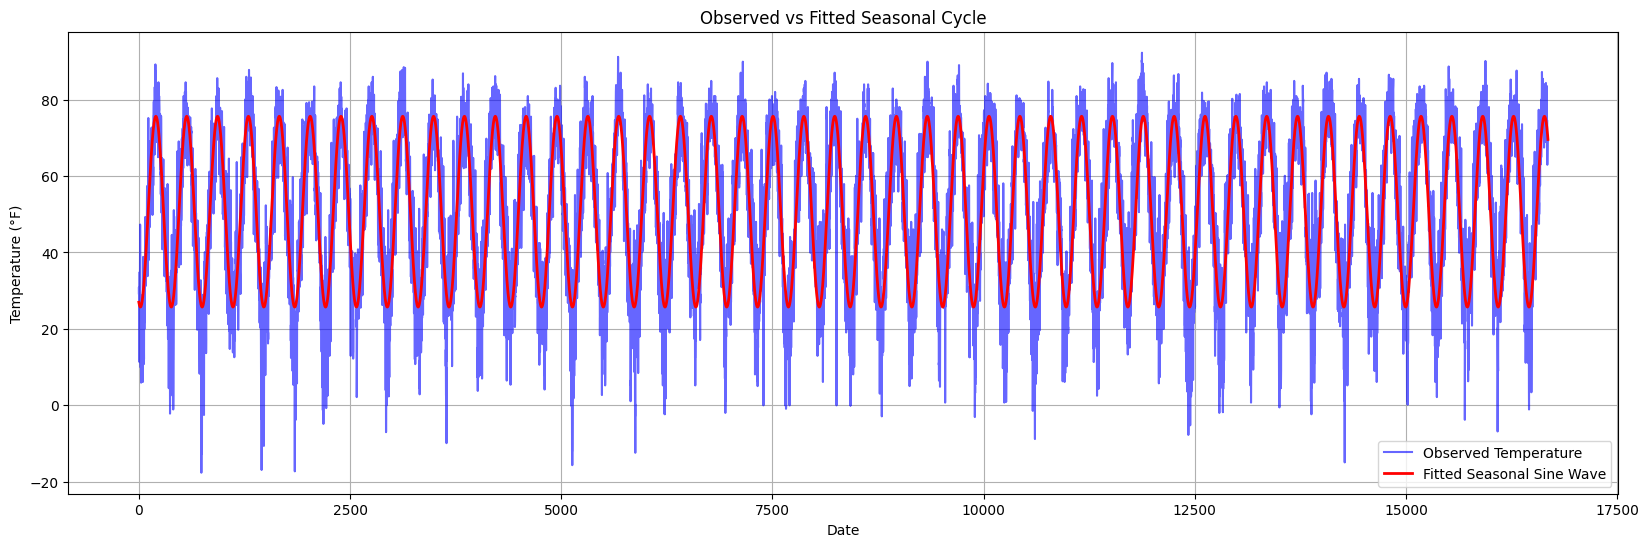

In [152]:
# Original data plot
plt.figure(figsize=(20,6))
plt.plot(data.index, data['tavg'], label='Observed Temperature', color='blue', alpha=0.6)

# Fitted sine wave plot
# Use the same x-scale as your data for smooth plotting
x_vals = np.arange(len(data.index))  # index as integers
sine_vals = sine_function(x_vals, A_fit, B_fit, C_fit, D_fit)

plt.plot(data.index, sine_vals, label='Fitted Seasonal Sine Wave', color='red', linewidth=2)

# Labels and formatting
plt.title("Observed vs Fitted Seasonal Cycle")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.show()

## Modeling the temperature differences 

We will now model a process for $ X_t - \mu_t $

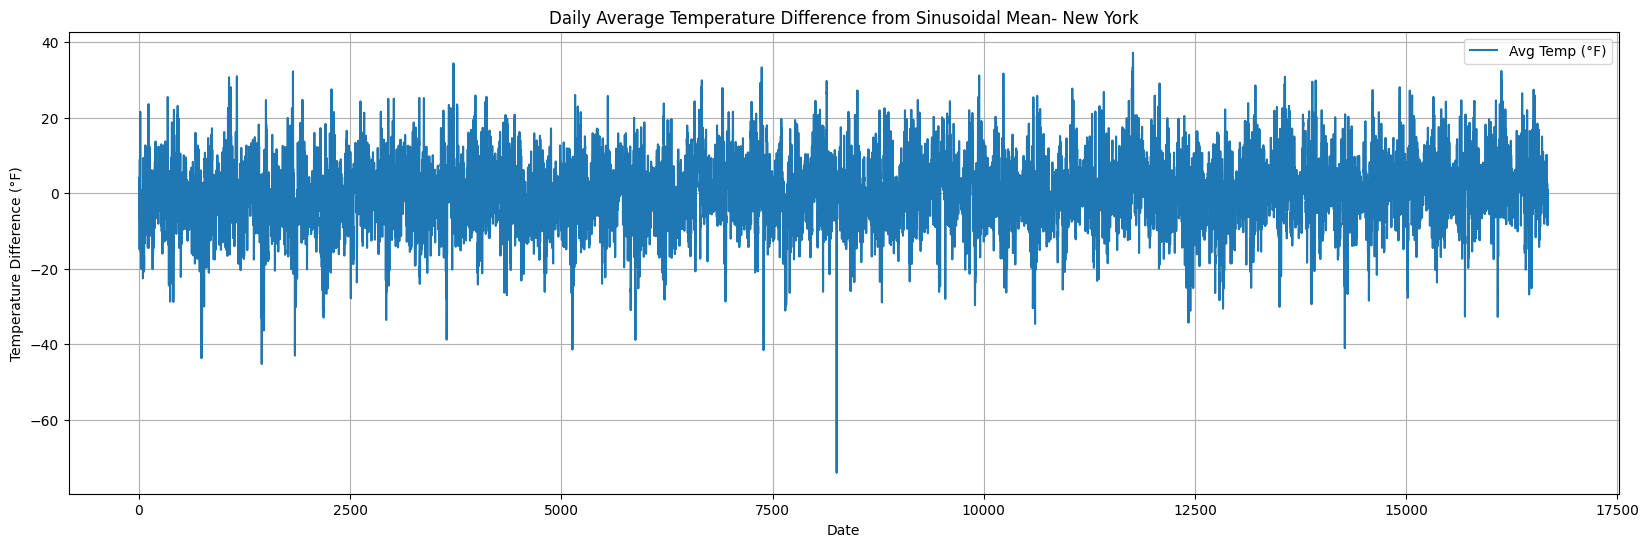

In [153]:
differences = data['tavg'] - sine_vals

plt.figure(figsize=(20,6))
plt.plot(data.index, differences, label='Avg Temp (°F)')
plt.title("Daily Average Temperature Difference from Sinusoidal Mean- New York")
plt.xlabel("Date")
plt.ylabel("Temperature Difference (°F)")
plt.legend()
plt.grid(True)
plt.show()

In [154]:
from statsmodels.graphics.tsaplots import plot_pacf



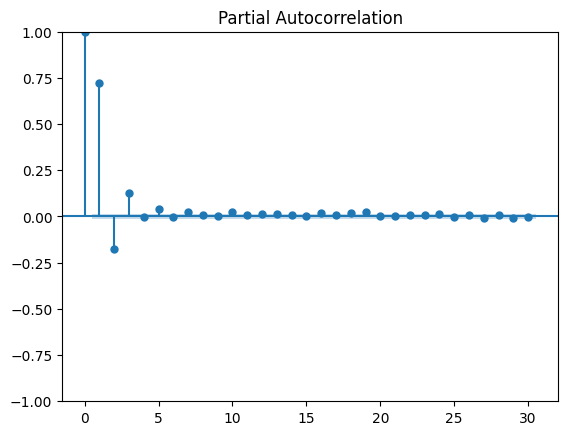

In [155]:
plot_pacf(differences.dropna(), lags=30, method='ywm')
plt.show()

In [156]:
def fit_ar_model(lags):
    model = AutoReg(differences, lags=lags, old_names=False)
    model_fit = model.fit()    
    return model_fit 

ar2 = fit_ar_model(2)
ar3 = fit_ar_model(3)
ar4 = fit_ar_model(4)

In [157]:
print(ar2.aic)
print(ar3.aic)
print(ar4.aic)

107445.16195431615
107165.59383041135
107162.06362022483


In [158]:
print(ar2.bic)
print(ar3.bic)
print(ar4.bic)

107476.0498170198
107204.20335902173
107208.39469481271


In [159]:
phi = ar3.params    # AR coefficients [phi1, phi2, phi3]
const = ar3.params[0]   # intercept
sigma = np.std(ar3.resid)  # residual std dev (innovation variance)

In [160]:
phi

const     -0.000242
tavg.L1    0.872072
tavg.L2   -0.284412
tavg.L3    0.128136
dtype: float64

## Monte Carlo Simulator

We have selected the AR(3) model for modeling temperature differences. Now, we will write code for a monte carlo simulation using said model

In [161]:
def monte_carlo_simulator(steps, simulations, starting_day, initial_temps):
    ds = np.array([day%365 for day in range(starting_day-3 , starting_day+steps)])
    sine_values = sine_function(ds, A_fit, B_fit, C_fit, D_fit)
    paths = []
    const = ar3.params[0]
    coeff_1 = ar3.params[1]
    coeff_2 = ar3.params[2]
    coeff_3 = ar3.params[3]
    for _ in range(simulations):
        path = [x for x in initial_temps]
        for j in range(3, steps+3):
            lag1_temp = path[j-1]
            lag2_temp = path[j-2]
            lag3_temp = path[j-3]
            harmonic_mus = sine_values[j-3 : j]
            diff_1 = lag1_temp - harmonic_mus[-1]
            diff_2 = lag2_temp - harmonic_mus[-2]
            diff_3 = lag3_temp - harmonic_mus[-3]
            next_temp = sine_values[j] + coeff_1*diff_1 + coeff_2*diff_2 + coeff_3*diff_3 + const + np.random.normal(0, sigma)
            path.append(next_temp)
        paths.append(path[3:])
    return paths

Simulating temperature paths for the month of January

In [162]:
paths = monte_carlo_simulator(30, 100000 , 0 , list(data['tavg'][-3:]))


In [163]:
len(paths[100])

30

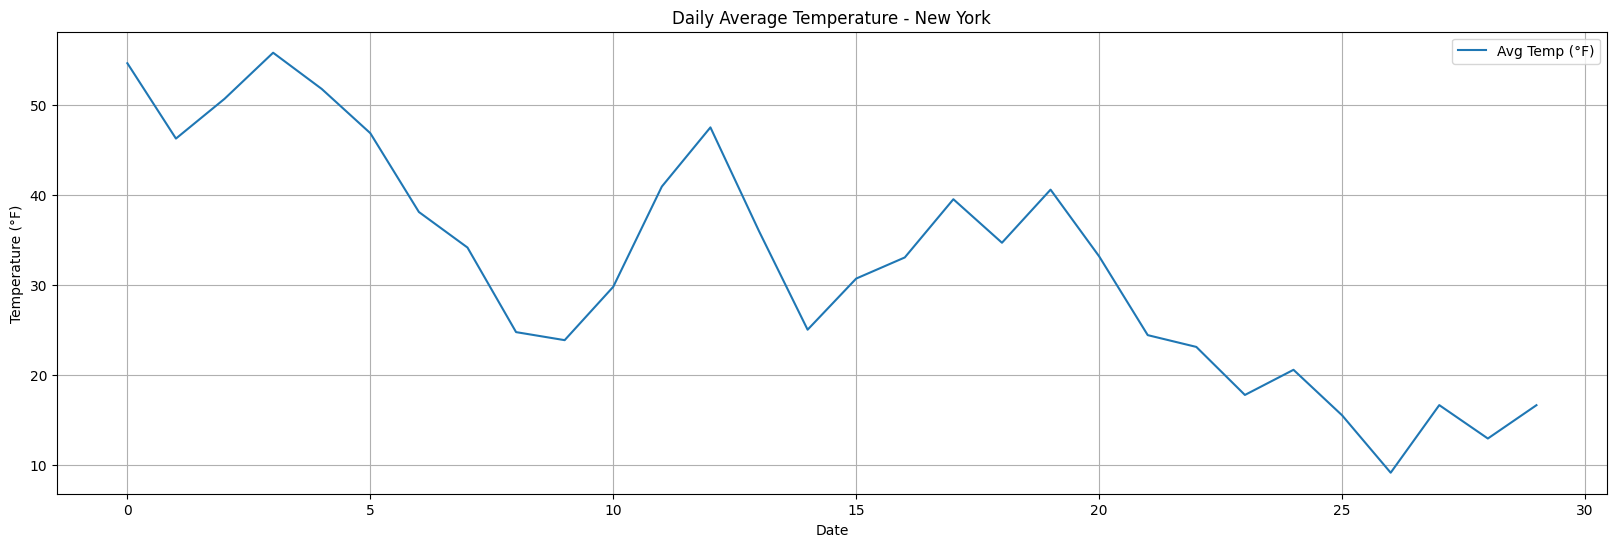

In [172]:
plt.figure(figsize=(20,6))
plt.plot(range(len(paths[100])), paths[100], label='Avg Temp (°F)')
plt.title("Daily Average Temperature - New York")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.show()

## Constructing HDD distribution

We will now use the simulated paths to construct a distribution for HDDs

In [165]:
hdds = []
i = 0
for path in paths :
    hdd = 0
    for temp in path :
        h = max(65-temp , 0)
        hdd += h 
    hdds.append(hdd)
    i += 1



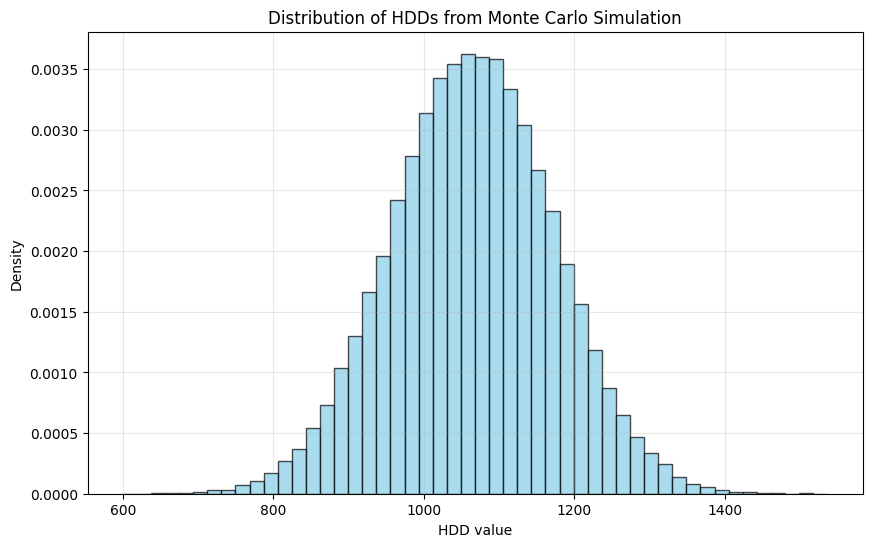

In [166]:
plt.figure(figsize=(10,6))
plt.hist(hdds, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
plt.title("Distribution of HDDs from Monte Carlo Simulation")
plt.xlabel("HDD value")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.show()

In [173]:
mean = np.mean(hdds)
std = np.std(hdds)

print(mean)
print(std)

1064.933504124111
107.96437234732511


## Market Calibration

These are sample quotes found on the CME website for Chicago HDD futures 


H2X5 → Chicago HDD Monthly Futures, Nov 2025 → Price 698.00

H2Z5 → Chicago HDD Monthly Futures, Dec 2025 → Price 1006.00

H2F6 → Chicago HDD Monthly Futures, Jan 2026 → Price 1223.00

H2G6 → Chicago HDD Monthly Futures, Feb 2026 → Price 997.00

H2H6 → Chicago HDD Monthly Futures, Mar 2026 → Price 756.00

Here Price is actually the implied HDD index calculated based on the price at which the security sold.

For this project, we will shift are distribution in order to price the contract. 

In [ ]:
mu_sim = np.mean(hdds)
mu_mkt = 1223  # CME price for Jan 2026

shift = mu_mkt - mu_sim

hdds_shifted = [hdd + shift for hdd in hdds]

mean = np.mean(hdds_shifted)

print(mean)
print(std)

1223.0000000000002
107.96437234732511


## Options Pricing and Greeks Calculation

We will use the final distribution to price options on Jan Chicago HDD futures. We will follow the Bachelier model and pick sample strike price and risk free interest rate and time to maturity 

### Example Strike, Maturity and Interest rate

1. Let Strike be mean + 0.7sigma 
2. Let Maturity be 1 month or 1/12 years
3. Let Interest Rate be 4 %

In [177]:
strike = mean + 0.7*std 
maturity = 1/12
rate = 0.04

### Option price 

As per the Bachelier Model , the call price is as follows : 

$$ 
C = e^{-rT}[(F-K)\theta(d) + \sigma\sqrt{T}\phi(d)]
$$

$$
d = (F-K)/\sigma\sqrt{T}
$$

In [178]:
from scipy.stats import norm

In [179]:
sigma_T = std * np.sqrt(maturity)

d = (mean - strike) / sigma_T

# Bachelier call price
call_price = np.exp(-rate*maturity) * ((mean - strike) * norm.cdf(d) + sigma_T * norm.pdf(d))

print(f"Bachelier Call Option Price: {call_price:.4f} HDD units")

# Dollar value (CME convention: 100 HDDs per contract, $20 per HDD)
notional = call_price * 100 * 20
print(f"≈ ${notional:,.2f} per contract")

Bachelier Call Option Price: 0.0784 HDD units
≈ $156.77 per contract


### Greeks Calculation 




- **Delta (sensitivity to forward HDD \(F\))**

$$
\Delta = \frac{\partial C}{\partial F} = e^{-rT} \,\Phi(d)
$$

- **Gamma (curvature wrt HDD)**

$$
\Gamma = \frac{\partial^2 C}{\partial F^2} 
= e^{-rT} \,\frac{\phi(d)}{\sigma\sqrt{T}}
$$

- **Vega (sensitivity to volatility)**

$$
\nu = \frac{\partial C}{\partial \sigma}
= e^{-rT} \,\sqrt{T}\,\phi(d)
$$

- **Theta (sensitivity to time decay)**

$$
\Theta = \frac{\partial C}{\partial T}
= -rC + \frac{e^{-rT}}{2}\frac{\sigma}{\sqrt{T}} \,\phi(d)
$$

- **Rho (sensitivity to interest rate \(r\))**

$$
\rho = \frac{\partial C}{\partial r} = -T \cdot C
$$



In [182]:
# calculate greeks in HDD terms

def bachelier_greeks(F, K, sigma, T, r=0.0, option="call"):
    sigma_T = sigma * np.sqrt(T)
    d = (F - K) / sigma_T
    
    # Price
    C = np.exp(-r*T) * ((F - K) * norm.cdf(d) + sigma_T * norm.pdf(d))
    
    # Greeks
    delta = np.exp(-r*T) * norm.cdf(d)
    gamma = np.exp(-r*T) * norm.pdf(d) / sigma_T
    vega  = np.exp(-r*T) * np.sqrt(T) * norm.pdf(d)
    theta = -r * C + np.exp(-r*T) * (-(F-K)/(2*T)) * norm.pdf(d) / sigma
    rho   = -T * C
    
    return {"Price": C, "Delta": delta, "Gamma": gamma, "Vega": vega, "Theta": theta, "Rho": rho}

In [183]:
greeks = bachelier_greeks(mean, strike, std, maturity, r=0.04)
greeks

{'Price': np.float64(0.07838267500671846),
 'Delta': np.float64(0.007631430311695147),
 'Gamma': np.float64(0.000674445403893537),
 'Vega': np.float64(0.006068006226158657),
 'Theta': np.float64(0.0851494917082802),
 'Rho': np.float64(-0.0065318895838932045)}